<a href="https://colab.research.google.com/github/ngockhanh5110/nlp-vietnamese-text-summarization/blob/main/notebooks/inferencing_vietnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install lib**

In [ ]:
!pip install vncorenlp datasets==1.0.2
!pip install transformers
!pip install dill==0.3.5.1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.1 MB/s eta 0:00:00
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=9e91101dea5249ea4a287a659ea824f04301ba177a784fde22639301724563f9
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install git-python==1.0.3
# !pip install sacrebleu==1.4.12
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=adce5ec46f4b5bdeb0d18f04fdd95020f376b2167aae640453c045be4661f4e5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import os
new_path = "/content/drive/MyDrive/LLM_TEXT/"
os.chdir(new_path)
current_path = os.getcwd()
print("current path:", current_path)

current path: /content/drive/MyDrive/LLM_TEXT


In [ ]:
import glob
import pandas as pd
import concurrent.futures
from datasets import *
import datasets
import transformers
import nltk
nltk.download('punkt')

from transformers import RobertaTokenizerFast,AutoTokenizer
from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Processing data**

In [ ]:
def listPaths(path):
  pathfiles = list()
  cnt = 0
  for pathfile in glob.glob(path):
    cnt += 1
    pathfiles.append(pathfile)
    if cnt == 10:
       break
  return pathfiles

test_paths = listPaths('/content/drive/MyDrive/LLM_TEXT/dataset/meeting/*.txt')
for file in test_paths:
  print(file)

/content/drive/MyDrive/LLM_TEXT/dataset/meeting/002.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/012.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/021.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/030.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/019.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/011.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/005.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/020.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/016.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/029.txt


In [ ]:
def read_content(path_file):
  """
  Input: Path of txt file
  Output
  """

  # print("\n\n path_file:", path_file)
  summary_content = ""
  summary_task = ""
  original = ""

  with open(path_file, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      cnt = 0
      for line in lines:
          line = line.strip()

          if line.startswith("NOI_DUNG_TOM_TAT"):
              cnt = 1
              line = line.replace("NOI_DUNG_TOM_TAT", "")
              line = line.replace(":", "")
          elif line.startswith("NHIEM_VU"):
              cnt = 2
              line = line.replace("NHIEM_VU", "")
              line = line.replace(":", "")
          elif line.startswith("NOI_DUNG_GOC"):
              cnt = 3
              line = line.replace("NOI_DUNG_GOC", "")
              line = line.replace(":", "")
          if line:
            if cnt == 1:
              summary_content += line
            elif cnt == 2:
              summary_task += line
            elif cnt == 3:
              original += line

  # print("summary_content:", summary_content)
  # print("summary_task:", summary_task)
  # print("original:", original)
  return {'file' : path_file,
          'summary_task': summary_task,
          'summary_content': summary_content,
          'original': original}

In [ ]:
def get_stop_words_vn(path):
    ret = []
    f = open(path, "r")
    lines = f.readlines()
    for line  in lines:
       line = line.replace("_", " ")
       line = " " + line.replace("\n", "") + " "
       ret.append(line)
    return ret

stop_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt")
task_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-dash.txt")
# print("stop_words", stop_words)
print("task_words", task_words)

task_words [' nhiệm vụ ', ' đảm nhiệm vai trò ', ' đảm nhận vai trò ', ' đảm nhận công việc ', ' đảm nhiệm nhiệm vụ ', ' được phân công việc ', ' được giao công việc ', ' đã giao cho ', ' phụ trách công việc ', ' sẽ giao công việc ', ' sẽ phân công việc ', ' phân công công việc ', ' sẽ tiến hành ']


In [ ]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')

def process_content_sentences( body: str, min_length=5, max_length=50):
        # for word in reversed(stop_words):
        #   body.replace(word, " ")
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

def detectTask(str):
  sentences = process_content_sentences(str, 1, 400)
  ret = ""
  for sentence in sentences:
    sentence = sentence.lower()
    for wTask in task_words:
      if wTask.strip() in sentence:
        # for word in reversed(stop_words):
        #   sentence = sentence.replace(word, " ")
        for word in reversed(stop_words):
          sentence = sentence.replace(word, " ")
        # print(sentence)
        ret += sentence
        break
  return ret

In [ ]:
txt = read_content("/content/drive/MyDrive/LLM_TEXT/dataset/meeting/023.txt")
print("summary_task: ", txt["summary_task"])
print ("result: ",detectTask(txt["summary_task"]))

summary_task:  Tú hoàn thành một phần công việc và đã gửi bản thiết kế sơ bộ cho mọi người xem qua qua email.Huy do hoàn cảnh gia đình, tôi không thể làm việc đúng tiến độ. Hiện tại, tôi đã hoàn thành 70% thiết kế trang chủ và sẽ gửi bản tóm tắt cho mọi người trong vòng 24 giờ tớTrọng sẽ tổ chức một cuộc họp nhỏ sau cuộc họp này để xác định lịch trình và phân công công việc. Trang thiết kế giao diện lịch sử giao dịch trên trang web quản lý chi tiêu.   Giao diện lịch sử giao dịch nên hiển thị danh sách các giao dịch trước đây của người dùng, kèm theo thông tin chi tiết và tiện ích tìm kiếm. Thời hạn  hoàn thành trong vòng 7 ngày.Huy  Nhiệm vụ  Thiết kế giao diện quản lý tài khoản trên trang web quản lý chi tiêu. Thời gian trong vòng  12 ngày .Trọng sẽ tiến hành giao việc thiết kế giao diện thông tin cá nhân của người dùng cho trang web quản lý chi tiêu, đã chuẩn bị một mô tả công việc chi tiết.Tú sẽ thiết kế trang cá nhân cho người dùng. Giao diện này nên cho phép người dùng cập nhật th

In [ ]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)

  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [ ]:
test_df = get_dataframe(test_paths)
print ("test_df", test_df["summary_task"], test_df["summary_content"] )

test_df 0    Chủ tịch công đoàn :  Tiến hành xây dựng  kế h...
1    Hà  sẽ tiến hành xây dựng  kế hoạch bài dạy đư...
2    Đơn vị quản lý A phụ trách công việc phân tích...
3    Quyên sẽ đảm nhận vai trò chính trong việc thi...
4    Đồng chí Hà  sẽ tiến hành xây dựng  kế hoạch b...
5    Phương sẽ đảm nhận vai trò chính trong việc th...
6    Lam sẽ đảm nhận vai trò chính trong việc phát ...
7    Đồng chí chủ tịch công đoàn  sẽ tiến hành xây ...
8    Tuấn đã  thiết kế và hoàn thiện một số phần củ...
9    Linh: Chủ tọa cuộc họp, giao việc cho các thàn...
Name: summary_task, dtype: object 0    Phân công công nhiệm vụ  cho việc xây dựng côn...
1    Phân công công việc cho việc xây dựng chuyên đ...
2    Dưới đây là phân công công việc cho dự án thiế...
3    Cuộc họp giao nhiệm vụ của công ty Việt á, chú...
4    Phân công công việc cho việc xây dựng chuyên đ...
5    Trong cuộc họp giao nhiệm vụ của công ty Vạn H...
6    Phân công nhiệm vụ code chức năng review cho h...
7    Phân công công nhi

In [ ]:
test_data =  Dataset.from_pandas(test_df)

In [ ]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

# **Inference**

In [ ]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/training/checkpoint-30000')
model.to("cpu")
batch_size = 32  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["original"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu")
    attention_mask = inputs.attention_mask.to("cpu")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [ ]:

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["original"])

result_summary_content = results["pred"]
summary_content_original = results["summary_content"]
summary_task_original = results["summary_task"]


print ("result_summary_content: ",result_summary_content[0] )

print ("file: ",test_data[0]["file"]  )
print ("summary_conten: ",summary_content_original[0] )
print ("summary_task: ",summary_task_original[0] )
print ("original: ",test_data[0]["original"] )

  0%|          | 0/1 [00:00<?, ?ba/s]

result_summary_content:  Ngày GD & ĐT THPT Nguyễn_Trãi ( Hoàng_Mai, Hà_Nội ) vừa ban_hành kế_hoạch công_tác năm_học mới 2019-2020. Theo đó, trong tháng 11, trường sẽ
file:  /content/drive/MyDrive/LLM_TEXT/dataset/meeting/030.txt
summary_conten:  Phân công công nhiệm vụ  cho việc xây dựng công tác tháng 11 năm học 2022- 2023 của trường TH Nguyễn Trãi
summary_task:  Chủ tịch công đoàn :  Tiến hành xây dựng  kế hoạch nhiệm vụ của công đoàn lập kế hoạch cho các hoạt động kỉ niêm 65 năm ngày hiến chương các nhà giáo 20/10  Thời gian thực hiện  từ 1/11  đến 18/11Tô trưởng chuyên môn :Chỉ  đạo các thành viên trong tổ thực hiện đúng chương trình các môn học theo thời khoá biểu được phân công ,thống nhất kế hoạch dạy học sao cho các hoạt động  dạy học phù hợp với nội dung của từng yêu cầu mà SGK đề cập đến, động viên các GV trong tổ ,hưởng ứng thi đua giờ dạy tốt chào mừng ngày nhà giáo Việt Nam Thời gian thực hiện: Từ ngày 1/11 đến ngày 19/11 Việt Nam 20/11.GV chủ nhiệm:  xây dựng kế hoạch của

In [ ]:
result_summary_task = []
for data in test_df["original"]:
  ret_task = detectTask(data)
  result_summary_task.append(ret_task)
  # print("data", data)
  # print('--->',ret_task, "\n")

### **Evaluation**


In [ ]:
print("Evaluation content")
rouge_summary_content = rouge.compute(predictions=result_summary_content, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_summary_content.items():
  print(key)
  print(value.mid)

Evaluation content
rouge1
Score(precision=0.5034507122975899, recall=0.5310964481758056, fmeasure=0.5034904064877377)
rouge2
Score(precision=0.16363053775662556, recall=0.16154057784492568, fmeasure=0.16070302394175906)
rougeL
Score(precision=0.30957902934179127, recall=0.3218988837076229, fmeasure=0.3072423248423234)


In [ ]:
print("Evaluation task")
rouge_summary_task = rouge.compute(predictions=result_summary_task, references=summary_task_original, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_summary_task.items():
  print(key)
  print(value.mid)

Evaluation task
rouge1
Score(precision=0.9245158412613395, recall=0.538393463003313, fmeasure=0.657857087965732)
rouge2
Score(precision=0.6170574105892872, recall=0.3554467795610713, fmeasure=0.4352487375582663)
rougeL
Score(precision=0.6580806259903251, recall=0.38956136143252695, fmeasure=0.4727969676970865)


# **Draw a comparison chart**

In [ ]:
models = ['Summary content', 'Summary task']
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []

rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []

rougel_recall = []
rougel_precision = []
rougel_f1 = []

def getRougeMyModel(rouge_output):
   for key,value in rouge_output.items():
      if key == "rouge1":
         rouge1_recall.append(value.mid[0])
         rouge1_precision.append(value.mid[1])
         rouge1_f1.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall.append(value.mid[0])
         rouge2_precision.append(value.mid[1])
         rouge2_f1.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[1])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[1])

print("Evaluation content")
getRougeMyModel(rouge_summary_content)
print("Evaluation task")
getRougeMyModel(rouge_summary_task)

Evaluation content
rouge1:recall 0.5034507122975899 -precision 0.5310964481758056 -F1-Score 0.5034904064877377
rouge2:recall 0.16363053775662556 -precision 0.16154057784492568 -F1-Score 0.16154057784492568
rougeL:recall 0.30957902934179127 -precision 0.3218988837076229 -F1-Score 0.3218988837076229
Evaluation task
rouge1:recall 0.9245158412613395 -precision 0.538393463003313 -F1-Score 0.657857087965732
rouge2:recall 0.6170574105892872 -precision 0.3554467795610713 -F1-Score 0.3554467795610713
rougeL:recall 0.6580806259903251 -precision 0.38956136143252695 -F1-Score 0.38956136143252695


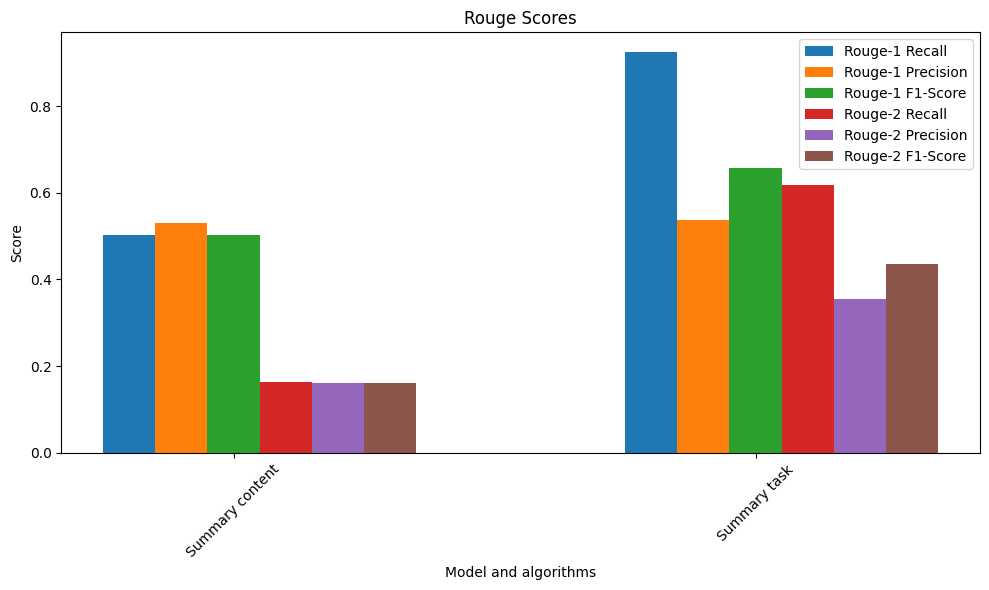

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(len(models))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1, width, label='Rouge-2 F1-Score')
plt.xlabel('Model and algorithms')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()